In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import os
os.chdir('/gdrive/My Drive/Bilgisayarli_Goru/')

In [3]:
!ls

data	      GAN4.2.ipynb     Obje_Tanima_Test.ipynb
GAN4.1.ipynb  keras-retinanet  Obje_Tanima_Train.ipynb


In [4]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [5]:
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace

/gdrive/My Drive/Bilgisayarli_Goru/keras-retinanet
Processing /gdrive/My Drive/Bilgisayarli_Goru/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=168031 sha256=ce6c91de050e44d95f20802c91b16ca833c97b27baa9485bcf76660c0c5c9d67
  Stored in directory: /root/.cache/pip/wheels/c7/81/f3/969e5a8e4a5d210475e092f612ae28fde3a6607fe18122d16b
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=09329f140a53d2dbfe07ea56689d4818d99228a1801acbe191bbf153d1cdebff
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet
running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/keras_retinanet/utils/compute_overlap.cpython-37m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import urllib
import os
from PIL import Image
import cv2

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import xml.etree.ElementTree as ET

In [7]:
df_train = pd.DataFrame()
for filename in os.listdir('/gdrive/My Drive/Bilgisayarli_Goru/data/'):
    if filename.split('.')[1] == 'xml':
        converted_data_train = {
        'image_name': [],
        'x_min': [],
        'y_min': [],
        'x_max': [],
        'y_max': [],
        'class_name': [],}

        tree = ET.parse("/gdrive/My Drive/Bilgisayarli_Goru/data/" +filename)
        root = tree.getroot()
        imname = root.find('filename').text
        converted_data_train['image_name'] ="/gdrive/My Drive/Bilgisayarli_Goru/data/" + imname

        for boxes in root.iter('object'):
            ymin, xmin, ymax, xmax = None, None, None, None
            objname = boxes.find("name").text
            converted_data_train['class_name'] = objname
            for box in boxes.findall("bndbox"):
                ymin = int(box.find("ymin").text)
                xmin = int(box.find("xmin").text)
                ymax = int(box.find("ymax").text)
                xmax = int(box.find("xmax").text)
                converted_data_train['x_min'] = int(xmin)
                converted_data_train['y_min'] = int(ymin)
                converted_data_train['x_max'] = int(xmax)
                converted_data_train['y_max'] = int(ymax)
            df_train = df_train.append(converted_data_train, ignore_index=True)

In [8]:
def show_image_with_boxes(df):
  filepath = df.sample()['image_name'].values[0]


  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))

  im = im[:,:,:3]

  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    draw_box(im, box, color=(0, 255, 0))

  plt.axis('off')
  plt.imshow(im)
  plt.show()

In [9]:
df_train

,class_name,image_name,x_max,x_min,y_max,y_min
0,black-king,/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_20...,2765.0,2093.0,1665.0,311.0
1,black-bishop,/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_20...,2688.0,2106.0,1524.0,370.0
2,black-king,/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_20...,2108.0,1724.0,1406.0,960.0
3,black-pawn,/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_20...,2431.0,1742.0,1565.0,427.0
4,black-queen,/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_20...,2736.0,1921.0,1750.0,127.0
...,...,...,...,...,...,...
393,white-bishop,/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_20...,2536.0,2333.0,1588.0,1386.0
394,white-knight,/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_20...,2301.0,2098.0,1583.0,1378.0
395,black-knight,/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_20...,2248.0,2045.0,1899.0,1696.0
396,black-bishop,/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_20...,2589.0,2375.0,1859.0,1651.0


In [10]:
df_train = df_train[['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_name']]

In [11]:
df_train = df_train.astype({"x_min": int, "y_min": int, "x_max": int, "y_max": int})

[2024, 1434, 2583, 2121]
[2952, 1501, 3580, 2042]
[2098, 498, 2601, 1311]
[2013, 1, 2442, 825]


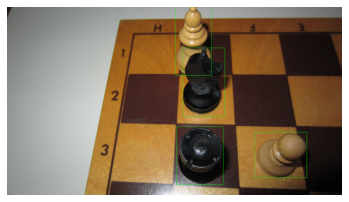

In [12]:
show_image_with_boxes(df_train)

In [13]:
df_train.to_csv('annotations.csv', index=False, header=None)

In [14]:
df_train.class_name.unique()

array(['black-king', 'black-bishop', 'black-pawn', 'black-queen',
       'black-rook', 'black-knight', 'white-pawn', 'white-bishop',
       'white-knight', 'white-rook', 'white-queen', 'white-king'],
      dtype=object)

In [15]:
classes = ['black-pawn', 'white-pawn', 'black-bishop', 'black-rook',
       'black-knight', 'white-bishop', 'white-queen', 'black-king',
       'white-knight', 'white-king', 'black-queen', 'white-rook']
with open('classes.csv', 'w') as f:
  for i, class_name in enumerate(classes):
    f.write(f'{class_name},{i}\n')

In [16]:
!head classes.csv

black-pawn,0
white-pawn,1
black-bishop,2
black-rook,3
black-knight,4
white-bishop,5
white-queen,6
black-king,7
white-knight,8
white-king,9


In [17]:
!head annotations.csv

/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_2017.JPG,2093,311,2765,1665,black-king
/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_2015.JPG,2106,370,2688,1524,black-bishop
/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_2018.JPG,1724,960,2108,1406,black-king
/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_2022.JPG,1742,427,2431,1565,black-pawn
/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_2020.JPG,1921,127,2736,1750,black-queen
/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_2021.JPG,1975,916,2503,1537,black-queen
/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_2009.JPG,2075,447,2516,1080,black-rook
/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_2012.JPG,1857,886,2298,1355,black-knight
/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_2010.JPG,1777,1,2560,1670,black-knight
/gdrive/My Drive/Bilgisayarli_Goru/data/IMG_2040.JPG,2024,1434,2583,2121,black-rook


In [18]:
if not os.path.exists('snapshots'):
  os.mkdir('snapshots')

In [19]:
PRETRAINED_MODEL = 'snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to snapshots/_pretrained_model.h5


In [20]:
!ls

annotations.csv      CONTRIBUTORS.md  LICENSE		   setup.cfg  ulus.jpg
build		     examples	      pretrained_model.h5  setup.py
classes.csv	     images	      README.md		   snapshots
coco_categories.txt  keras_retinanet  requirements.txt	   tests


In [38]:
%cd /gdrive/My Drive/Bilgisayarli_Goru/keras-retinanet/

/gdrive/My Drive/Bilgisayarli_Goru/keras-retinanet


In [40]:
!keras_retinanet/bin/train.py  --freeze-backbone \
  --random-transform \
  --weights {PRETRAINED_MODEL} \
  --batch-size 4 \
  --steps 20 \
  --epochs 80 \
  csv annotations.csv classes.csv

/bin/bash: keras_retinanet/bin/train.py: /usr/bin/env: bad interpreter: Permission denied
